# guidance for Gaussian process regression

In this part, two single fidelity gpr models will be introduced. The first model
is Kriging model which aims to model the noiseless case; the second model is Gaussian process regressor which aims to model the case with noise.


## Kriging model


In [1]:
# third party packages
import matplotlib.pyplot as plt
import numpy as np

# local funstions
from mfpml.models.sf_gpr import Kriging
from mfpml.problems.singlefidelity_functions import Forrester

In [2]:
# define function
func = Forrester()

# initialize sampler

sample_x = np.array([0.0, 0.4, 0.6, 1.0]).reshape((-1, 1))
test_x = np.linspace(0, 1, 1001, endpoint=True).reshape(-1, 1)

# get the function value
sample_y = func.f(sample_x)
test_y = func.f(test_x)

In [3]:
# train the model
sfK = Kriging(design_space=func._input_domain)
sfK.train(sample_x, sample_y)
sf_pre, sf_std = sfK.predict(test_x, return_std=True)

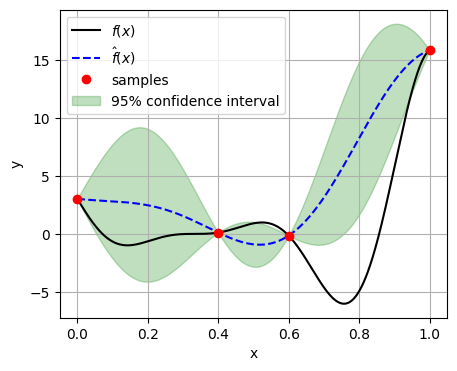

In [5]:
# plot the prediction
fig, ax = plt.subplots(figsize=(5, 4))
ax.plot(test_x, test_y, "k-", label=r"$f(x)$")
ax.plot(test_x, sf_pre, "b--", label=r"$\hat{f}(x)$")
ax.plot(sample_x, sample_y, "ro", label="samples")
ax.fill_between(
    test_x.reshape(-1),
    (sf_pre - 1.96 * sf_std).reshape(-1),
    (sf_pre + 1.96 * sf_std).reshape(-1),
    alpha=0.25,
    color="g",
    label="95% confidence interval",
)
ax.legend(loc="best")
ax.grid()
plt.xlabel("x")
plt.ylabel("y")
plt.savefig("kriging.png", dpi=300, bbox_inches="tight")
plt.show()

## Gaussian process regression model


In [6]:
from mfpml.models.sf_gpr import GaussianProcessRegressor
from mfpml.optimization.evolutionary_algorithms import DE
from mfpml.design_of_experiment.singlefideliy_samplers import LatinHyperCube

In [8]:
# sampling by sampling method
sampler = LatinHyperCube(design_space=func._design_space, seed=1)
sample_x = sampler.get_samples(num_samples=60)
test_x = np.linspace(0, 1, 101, endpoint=True).reshape(-1, 1)

# get samples by adding noise to the true function
sample_y = func.f(sample_x) + np.random.normal(0, 0.2,
                                               sample_x.shape[0]).reshape((-1, 1))
test_y = func.f(test_x) + np.random.normal(0, 0.2,
                                           test_x.shape[0]).reshape((-1, 1))
test_mean = func.f(test_x)

In [9]:
# initialize optimizer
optimizer = DE(num_gen=1000, num_pop=50, crossover_rate=0.5,
               strategy="DE/best/1/bin")
# initialize the regressor
sfK = GaussianProcessRegressor(
    design_space=func._input_domain, optimizer=optimizer)
# train the model
sfK.train(sample_x, sample_y)
# get the prediction
sf_pre, sf_std, aleatoric = sfK.predict(test_x, return_std=True)

In [10]:
# output the learned noise level
print(sfK.noise)

0.22227570221059303


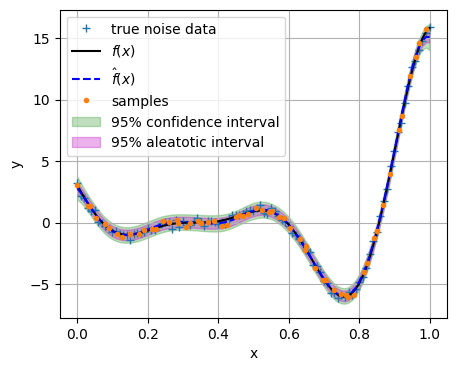

In [11]:
fig, ax = plt.subplots(figsize=(5, 4))
ax.plot(test_x, test_y, "+", label="true noise data")
ax.plot(test_x, test_mean, "k-", label=r"$f(x)$")
ax.plot(test_x, sf_pre, "b--", label=r"$\hat{f}(x)$")
ax.plot(sample_x, sample_y, ".", label="samples")
ax.fill_between(
    test_x.reshape(-1),
    (sf_pre - 1.96 * sf_std).reshape(-1),
    (sf_pre + 1.96 * sf_std).reshape(-1),
    alpha=0.25,
    color="g",
    label="95% confidence interval",
)
ax.fill_between(
    test_x.reshape(-1),
    (sf_pre - 1.96 * aleatoric).reshape(-1),
    (sf_pre + 1.96 * aleatoric).reshape(-1),
    alpha=0.3,
    color="m",
    label="95% aleatotic interval",
)
ax.legend(loc="best")
ax.grid('--')
plt.xlabel("x")
plt.ylabel("y")
plt.savefig("mix_kriging.png", dpi=300, bbox_inches="tight")
plt.show()